In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install -q tensorflow-addons
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# https://www.kaggle.com/datasets/mostafaabla/garbage-classification
root='/kaggle/input/garbage-classification/garbage_classification/'
data={}
for i in os.listdir(root):
    print(i)
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i

metal
white-glass
biological
paper
brown-glass
battery
trash
cardboard
shoes
clothes
plastic
green-glass


In [4]:
data=pd.DataFrame(data.items(),columns=['path','label'])
data=data.sample(frac=1)
data

,path,label
421,/kaggle/input/garbage-classification/garbage_c...,metal
4670,/kaggle/input/garbage-classification/garbage_c...,battery
1107,/kaggle/input/garbage-classification/garbage_c...,white-glass
12899,/kaggle/input/garbage-classification/garbage_c...,clothes
15015,/kaggle/input/garbage-classification/garbage_c...,green-glass
...,...,...
15419,/kaggle/input/garbage-classification/garbage_c...,green-glass
11235,/kaggle/input/garbage-classification/garbage_c...,clothes
7112,/kaggle/input/garbage-classification/garbage_c...,shoes
11895,/kaggle/input/garbage-classification/garbage_c...,clothes


In [5]:
data["label"].value_counts()

clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: label, dtype: int64

In [6]:
new_data = data[data['label'].isin(['metal', 'white-glass', 'plastic'])]
new_data = new_data.sample(frac=1)

In [7]:
new_data

,path,label
1355,/kaggle/input/garbage-classification/garbage_c...,white-glass
14323,/kaggle/input/garbage-classification/garbage_c...,plastic
1440,/kaggle/input/garbage-classification/garbage_c...,white-glass
192,/kaggle/input/garbage-classification/garbage_c...,metal
657,/kaggle/input/garbage-classification/garbage_c...,metal
...,...,...
14298,/kaggle/input/garbage-classification/garbage_c...,plastic
14464,/kaggle/input/garbage-classification/garbage_c...,plastic
1288,/kaggle/input/garbage-classification/garbage_c...,white-glass
14411,/kaggle/input/garbage-classification/garbage_c...,plastic


In [8]:
#Setting the number of files we want in each class. This is the number of metal images in this case since that is the class with the least number of images. 
file_count = 769
#Create samples list for putting the number of images we want of each class in.
samples = []
#Iterate over each class in the dataframe.
for category in new_data['label'].unique():    
    #Slice the certain category.
    category_slice = new_data.query("label == @category")
    #Take a sample of file_count, set to 607 above, of each slice and set a random_state to make it repeatable. 
    samples.append(category_slice.sample(file_count, replace=False,random_state=666))
#Set the dataframe to the samples list. 
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=666).reset_index(drop=True)
#Print the amount of classes and the length of the dataframe to make sure we balanced the dataframe. 
print (df['label'].value_counts())
print (len(df))

white-glass    769
metal          769
plastic        769
Name: label, dtype: int64
2307


In [9]:
def split_data(data,ratio):
    last=int(len(data)*ratio)
    return data[:last], data[last:]

In [10]:
train,test=split_data(df,.8)

In [11]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [12]:
train["label"].value_counts()

plastic        626
white-glass    616
metal          603
Name: label, dtype: int64

In [13]:
test["label"].value_counts()

metal          166
white-glass    153
plastic        143
Name: label, dtype: int64

In [14]:
train,valid=split_data(train,.9)

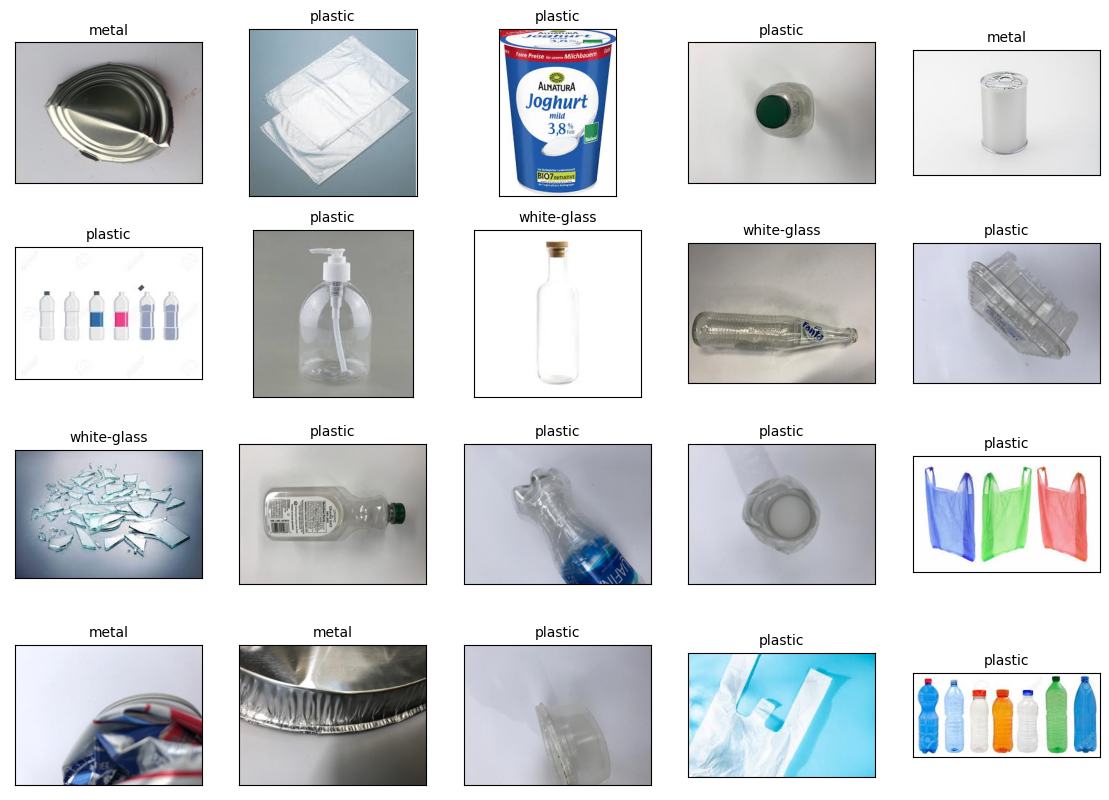

In [15]:
import matplotlib.pyplot as plt
import numpy as np
#Create a new matplotlib figure and make it 14 by 10 inches in size.
plt.figure(figsize=(14,10))
for i in range(20):
    #Find a random number which is inside of the dataset index.
    random = np.random.randint(1,len(df))
    #Create a subplot which is 4 by 5 and put the image in the i+1 position in the plot.
    plt.subplot(4,5,i+1)
    #Locate the image path within the dataframe using the random index we generated above.
    img = df.loc[random,"path"]
    #Use matplotlib to read and show the image. 
    plt.imshow(plt.imread(img))
    #Title the subplot by locating the label for the image in the dataframe using the same random index.
    plt.title(df.loc[random, "label"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])

#Show the plot of images.
plt.show()

In [16]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
size=224

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='label',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=666,
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)
val_images = train_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='path',
    y_col='label',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=666,
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)
test_images = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='label',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=666,
)

Found 1660 validated image filenames belonging to 3 classes.
Found 185 validated image filenames belonging to 3 classes.
Found 462 validated image filenames belonging to 3 classes.


In [17]:
!git clone https://github.com/AbdelrhmanNile/TrashVision

fatal: destination path 'TrashVision' already exists and is not an empty directory.


In [17]:
encoder = keras.models.load_model("TrashVision/machinelearning/autoencoder/encoder_model.h5")

In [18]:
# freeze encoder layers
for layer in encoder.layers:
    layer.freeze=True

In [19]:
import tensorflow_hub as hub
def get_from_hub(model_url):
    inputs = tf.keras.Input((224, 224, 3), name="inputt")
    hub_module = hub.KerasLayer(model_url,trainable=False, name="swin")
    outputs = hub_module(inputs)
    return tf.keras.Model(inputs, outputs)

In [20]:
swin_transformer = get_from_hub('https://tfhub.dev/sayakpaul/swin_tiny_patch4_window7_224_fe/1')

In [21]:
def se_block(inputs):
    input_channels = inputs.shape[-1]
    x = keras.layers.GlobalAveragePooling2D(name="gap1")(inputs)
    x = keras.layers.Dense(units=len(train_images.class_indices.keys()), activation="relu")(x)    
    x = keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

In [25]:
def build_classifier():
    # swin feature extractor
    swin_output = swin_transformer.output
    x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(swin_output)
    x = keras.layers.Dense(512, kernel_regularizer = keras.regularizers.l2(l = 0.016),activity_regularizer=keras.regularizers.l1(0.006),
                           bias_regularizer=keras.regularizers.l1(0.006) ,activation='relu')(x)
    x = keras.layers.Dense(256,activation='relu')(x)
    x_swin = keras.layers.Dense(128, activation='relu')(x)
    
    # our encoder
    encoder_output = encoder.output
    x = se_block(encoder_output)
    x = keras.layers.GlobalAveragePooling2D(name="gap2")(x)
    x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = keras.layers.Dense(512, kernel_regularizer = keras.regularizers.l2(l = 0.016),activity_regularizer=keras.regularizers.l1(0.006),
                           bias_regularizer=keras.regularizers.l1(0.006) ,activation='relu')(x)
    x = keras.layers.Dense(256,activation='relu')(x)
    x_encoder = keras.layers.Dense(128, activation='relu')(x)
    
    # concat swin features and encoder features
    x_conc = keras.layers.concatenate([x_encoder,x_swin])
    
    output = keras.layers.Dense(3, activation='softmax')(x_conc)
    
    return keras.models.Model(inputs=[encoder.input, swin_transformer.input], outputs=output)

In [26]:
model = build_classifier()

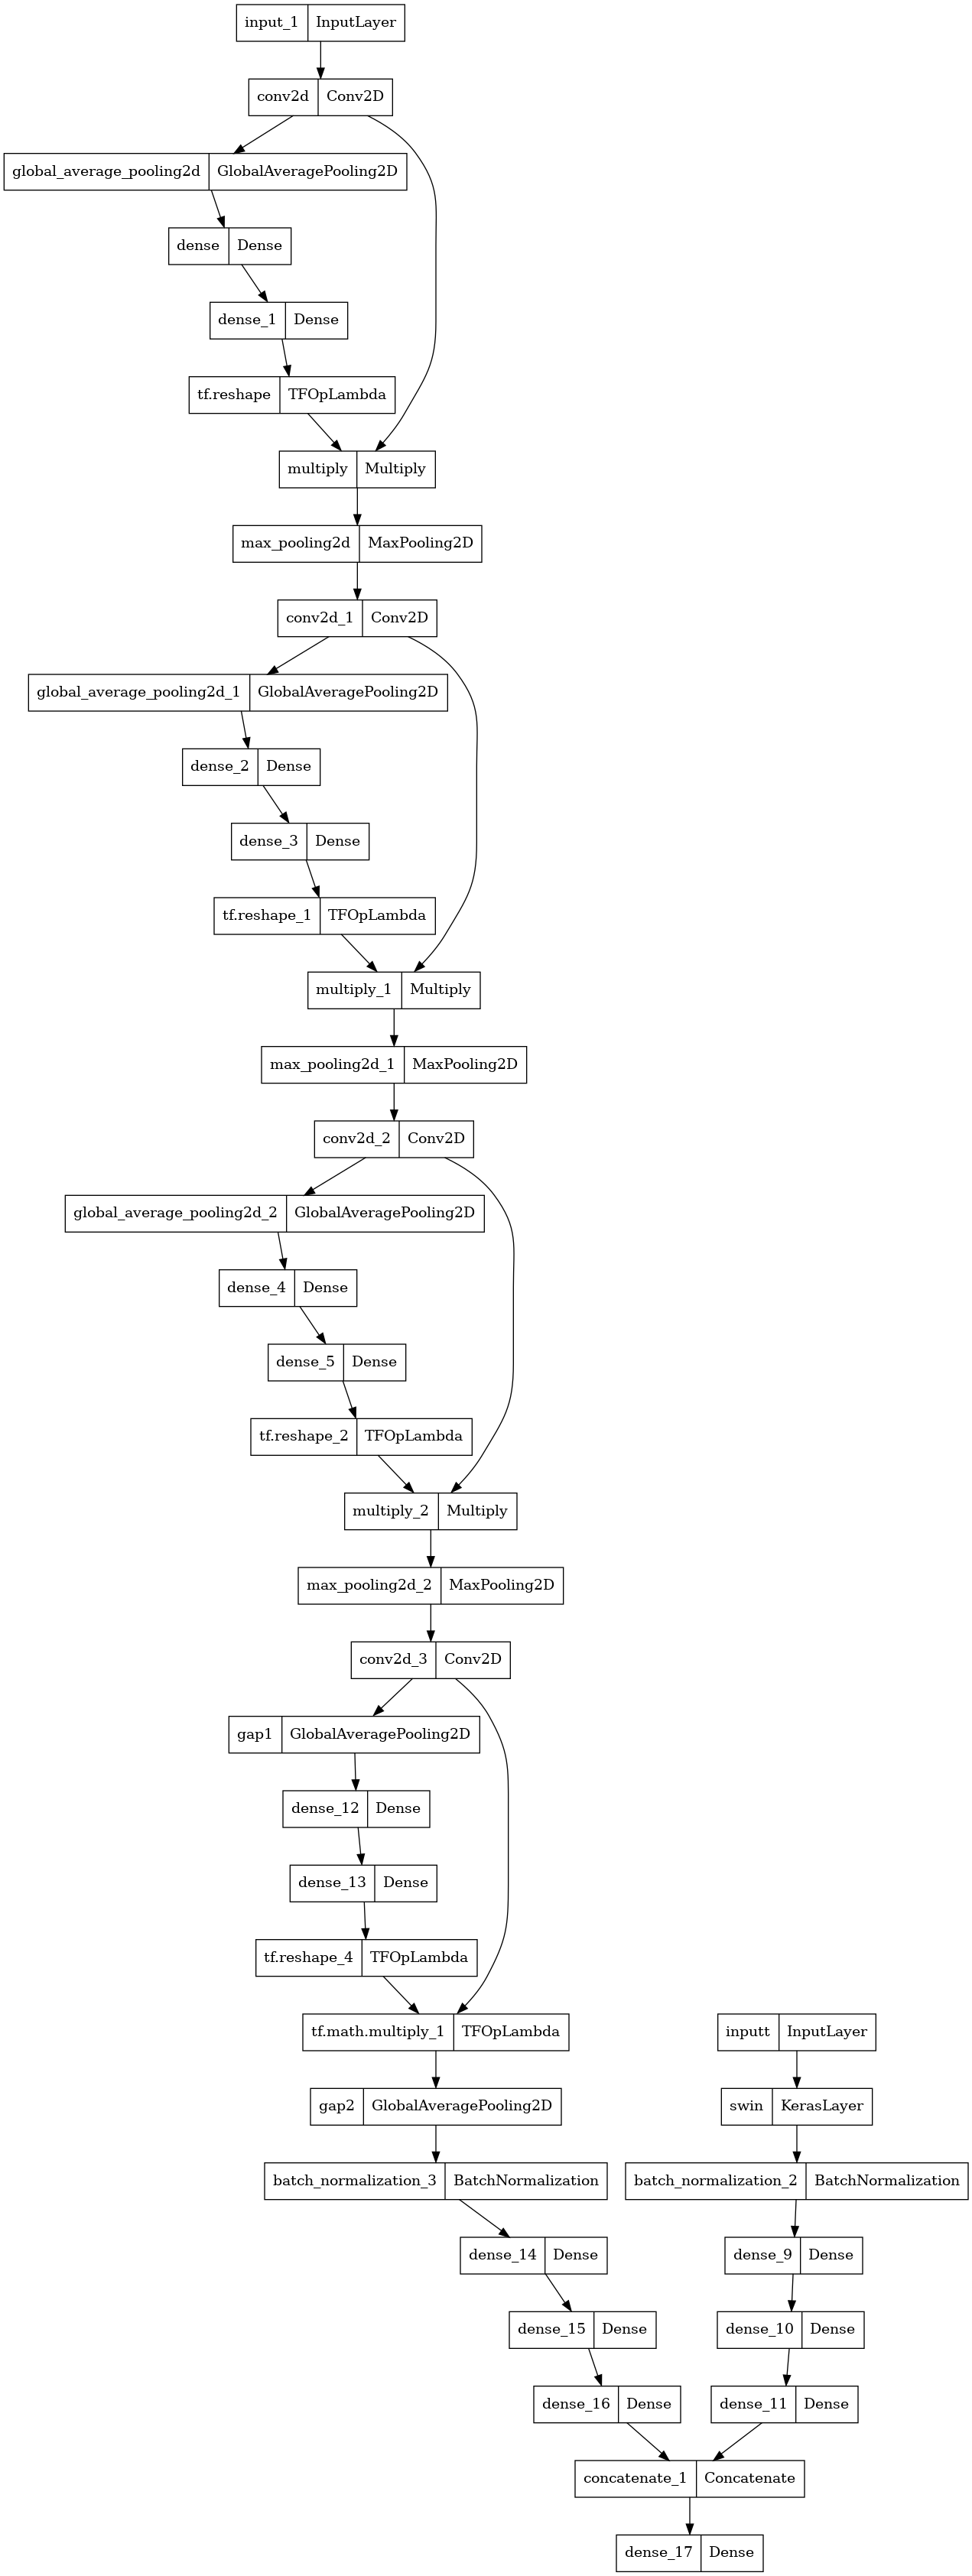

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [28]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 48  1344        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 48)          0           ['conv2d[0][0]']                 
 alAveragePooling2D)                                                                        

In [29]:
def gen_two_img(gen):
    while True:
        X1i = gen.next()
        yield [X1i[0],X1i[0]], X1i[1]

In [30]:
f1 = tfa.metrics.f_scores.F1Score(num_classes=3, average='micro', threshold=0.5)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy', f1])

In [31]:
history = model.fit(
    gen_two_img(train_images),
    validation_data=gen_two_img(val_images), 
    validation_steps=val_images.n//batch_size,
    validation_batch_size=batch_size,
    steps_per_epoch=train_images.n//batch_size,
    batch_size=batch_size,
    epochs=50,
)

Epoch 1/50
103/103 [==============================] - 66s 389ms/step - loss: 6.2233 - accuracy: 0.8149 - f1_score: 0.8061 - val_loss: 3.1181 - val_accuracy: 0.4489 - val_f1_score: 0.4583
Epoch 2/50
103/103 [==============================] - 30s 292ms/step - loss: 1.6784 - accuracy: 0.8747 - f1_score: 0.8743 - val_loss: 1.3093 - val_accuracy: 0.8011 - val_f1_score: 0.7379
Epoch 3/50
103/103 [==============================] - 27s 268ms/step - loss: 0.9472 - accuracy: 0.8796 - f1_score: 0.8749 - val_loss: 0.8914 - val_accuracy: 0.8409 - val_f1_score: 0.8088
Epoch 4/50
103/103 [==============================] - 28s 269ms/step - loss: 0.7142 - accuracy: 0.9015 - f1_score: 0.9000 - val_loss: 0.6749 - val_accuracy: 0.8864 - val_f1_score: 0.8757
Epoch 5/50
103/103 [==============================] - 28s 270ms/step - loss: 0.6542 - accuracy: 0.9027 - f1_score: 0.9037 - val_loss: 0.6976 - val_accuracy: 0.8636 - val_f1_score: 0.8547
Epoch 6/50
103/103 [==============================] - 28s 269ms/s

(<Figure size 1500x500 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <AxesSubplot: title={'center': 'F1 Score'}, xlabel='Epochs', ylabel='F1 Score'>],
       dtype=object))

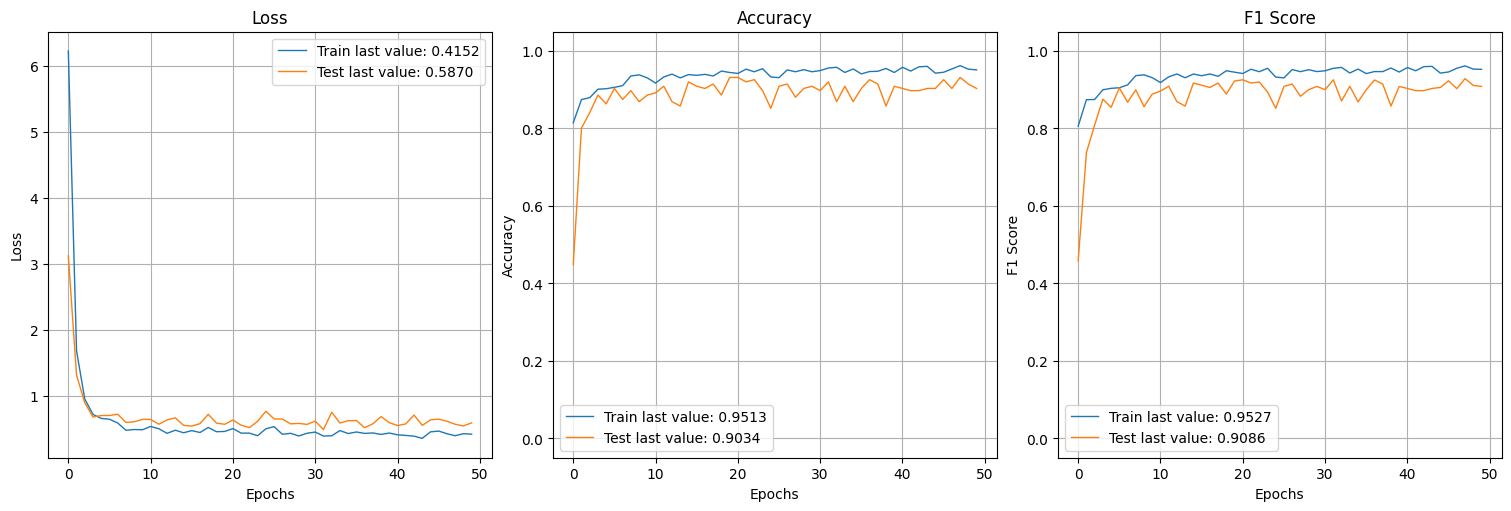

In [32]:
!pip install -q plot_keras_history
from plot_keras_history import plot_history
plot_history(history)

In [33]:
model.save("model.h5")

In [34]:
labels = train_images.class_indices.keys()

In [35]:
labels

dict_keys(['metal', 'plastic', 'white-glass'])

In [36]:
def prediction_generator(test_images):
    k=0
    for x in test_images:
        k+=len(x[1])
        yield [x[0],x[0]], x[1]
        if(k>=test_images.n):
            break

In [184]:
def pred(img):
    labels = ['metal', 'plastic', 'white-glass']
    im = np.expand_dims(img, 0)
    pred = model.predict([im, im])
    print(pred)
    idx = np.argmax(pred, 1)[0]
    return labels[idx]
    

In [160]:
!wget https://c0.wallpaperflare.com/preview/54/804/868/adversting-blue-can-cold-drink.jpg

--2023-05-19 17:05:19--  https://c0.wallpaperflare.com/preview/54/804/868/adversting-blue-can-cold-drink.jpg
Resolving c0.wallpaperflare.com (c0.wallpaperflare.com)... 104.21.235.72, 104.21.235.71, 2606:4700:3038::6815:eb47, ...
Connecting to c0.wallpaperflare.com (c0.wallpaperflare.com)|104.21.235.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49504 (48K) [image/jpeg]
Saving to: ‘adversting-blue-can-cold-drink.jpg’

adversting-blue-can 100%[===================>]  48.34K  --.-KB/s    in 0.006s  

2023-05-19 17:05:20 (7.94 MB/s) - ‘adversting-blue-can-cold-drink.jpg’ saved [49504/49504]



In [161]:
import cv2


In [162]:
test_im = cv2.imread("adversting-blue-can-cold-drink.jpg")

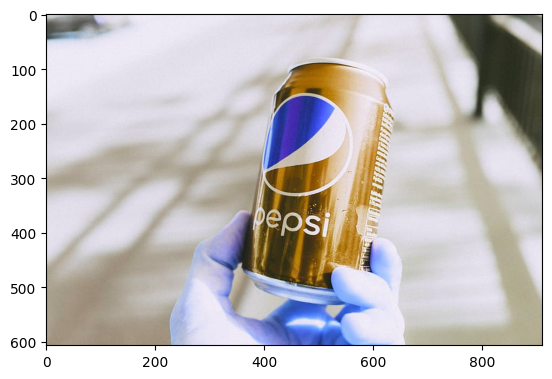

In [167]:
plt.imshow(test_im)

In [181]:
resized = cv2.resize(test_im, (224,224))

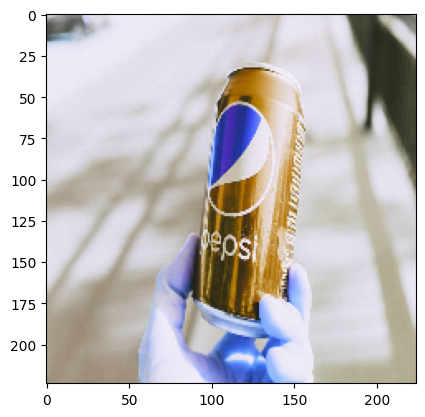

In [182]:
plt.imshow(resized)

In [187]:
pred(resized/255.0)

1/1 [==============================] - 0s 50ms/step
[[0.8789113  0.10588422 0.01520449]]


'metal'